# A. Loading & Scaling

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Combine all data and labels
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])

# Filter only T-shirt/top (0) and Trouser (1)
mask = np.isin(y_all, [0, 1])
x_filtered = x_all[mask]
y_filtered = y_all[mask]

# Preprocessing: normalize and reshape
x_filtered = x_filtered.astype('float32') / 255.0
x_filtered = x_filtered.reshape((-1, 28, 28, 1))

# Split the data into 80% train, 10% val, and 10% test
x_train, x_temp, y_train, y_temp = train_test_split(x_filtered, y_filtered, train_size=0.8, stratify=y_filtered, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)

# Print the shape of the datasets
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")


2024-07-07 20:33:10.409401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 20:33:10.409570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 20:33:10.527273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set shape: (11200, 28, 28, 1)
Validation set shape: (1400, 28, 28, 1)
Test set shape: (1400, 28, 28, 1)


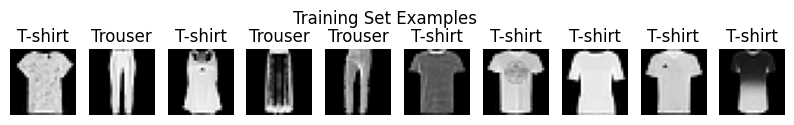

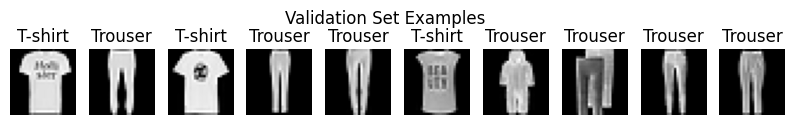

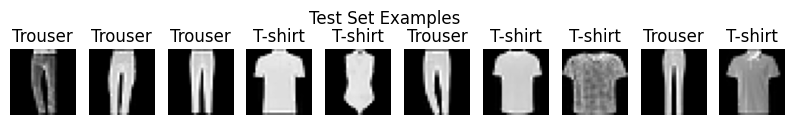

In [2]:
# Function to plot example images
def plot_examples(images, labels, title, num_examples=10):
    plt.figure(figsize=(10, 1.5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"{'T-shirt' if labels[i] == 0 else 'Trouser'}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plot examples from training set
plot_examples(x_train, y_train, 'Training Set Examples')

# Plot examples from validation set
plot_examples(x_val, y_val, 'Validation Set Examples')

# Plot examples from test set
plot_examples(x_test, y_test, 'Test Set Examples')


Pada bagian ini, saya memuat dataset Fashion MNIST, menggabungkan data pelatihan dan pengujian, serta memfilter hanya gambar dengan label T-shirt/top (0) dan Trouser (1). Setelah itu, saya melakukan praproses dengan menormalisasi dan mengubah bentuk gambar menjadi format yang sesuai untuk digunakan dalam model deep learning. Dataset yang sudah difilter kemudian dibagi menjadi tiga bagian: 80% untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian menggunakan `train_test_split` dari sklearn. Saya juga menambahkan fungsi untuk menampilkan contoh gambar dari setiap set data (pelatihan, validasi, pengujian) menggunakan Matplotlib, sehingga kita dapat melihat representasi visual dari data yang digunakan.

# B. Baseline

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import numpy as np
from kerastuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
def create_autoencoder():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(128, activation='relu')(x)
    # Decoder
    x = layers.Dense(6272, activation='relu')(encoded)
    x = layers.Reshape((14, 14, 32))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # Model Autoencoder
    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

autoencoder = create_autoencoder()
history = autoencoder.fit(x_train, x_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(x_val, x_val),
                          verbose=1)

def calculate_ssim(original, reconstructed):
    return ssim(original.squeeze(), reconstructed.squeeze(), data_range=1.0)

reconstructed_images = autoencoder.predict(x_test)
ssim_scores = [calculate_ssim(original, reconstructed) 
               for original, reconstructed in zip(x_test, reconstructed_images)]

average_ssim = np.mean(ssim_scores)
print(f"Rata-rata SSIM pada data test: {average_ssim:.4f}")

/tmp/ipykernel_34/2143697641.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


Epoch 1/50
19/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5933

I0000 00:00:1720384413.959301     178 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720384413.978851     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384413.980847     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5106

W0000 00:00:1720384417.047205     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384417.680477     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.5084 - val_loss: 0.3218
Epoch 2/50
13/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3218

W0000 00:00:1720384418.555619     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3124 - val_loss: 0.2879
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2840 - val_loss: 0.2728
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2703 - val_loss: 0.2660
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2644 - val_loss: 0.2626
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2613 - val_loss: 0.2584
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2567 - val_loss: 0.2561
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2569 - val_loss: 0.2546
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2541 - val_loss: 0.2530
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2528 - val_loss: 0.2522
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2528 - val_loss: 0.2515
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2528 - val_loss: 0.2500
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2492 - val_

Pada bagian ini, saya membuat dan melatih model autoencoder menggunakan dataset Fashion MNIST yang telah difilter dan dibagi sebelumnya. Model autoencoder terdiri dari encoder yang mengompresi input gambar menjadi representasi laten, dan decoder yang merekonstruksi gambar dari representasi tersebut. Setelah mendefinisikan arsitektur model, saya melatihnya selama 50 epoch dengan menggunakan `x_train` untuk pelatihan dan `x_val` untuk validasi. Setelah pelatihan, saya menggunakan model autoencoder untuk merekonstruksi gambar dari set pengujian (`x_test`). Untuk mengevaluasi kualitas rekonstruksi, saya menghitung Structural Similarity Index Measure (SSIM) antara gambar asli dan gambar yang direkonstruksi. Rata-rata nilai SSIM menunjukkan seberapa baik model merekonstruksi gambar, dengan hasil rata-rata SSIM dicetak untuk data pengujian.

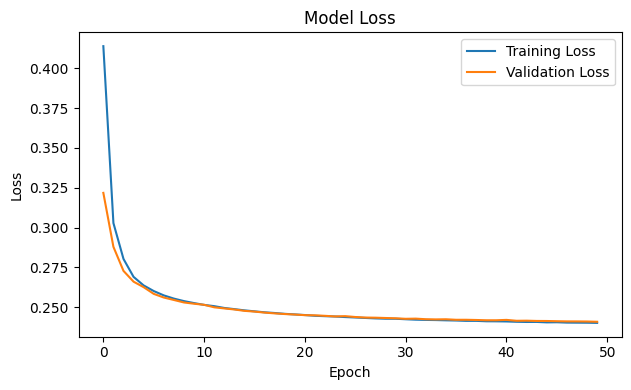

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

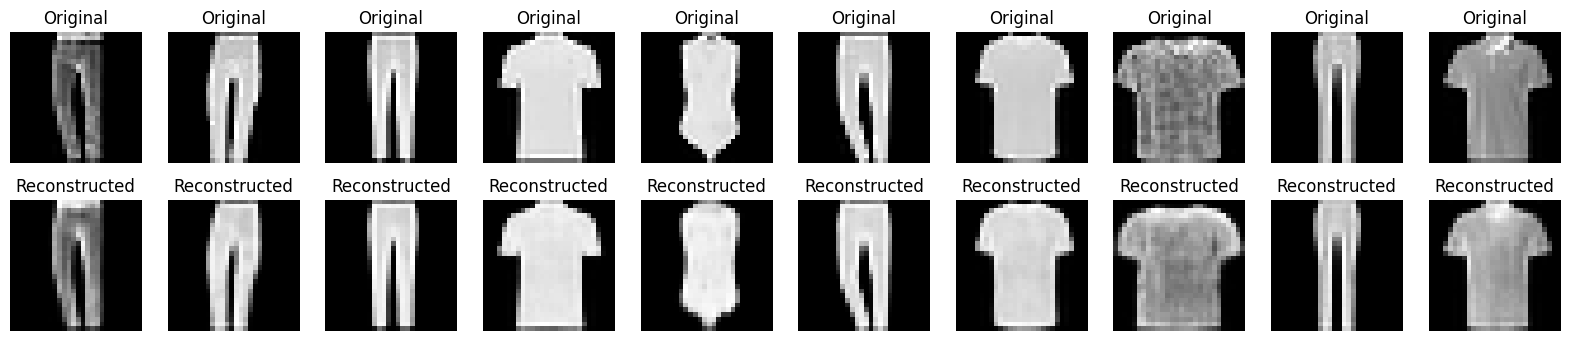

In [5]:
def visualize_reconstructions(original_images, reconstructed_images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Call the function to visualize the reconstructions
visualize_reconstructions(x_test, reconstructed_images)

# C. Tuned

# Manual

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import numpy as np
from kerastuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
def create_autoencoder():
    # Encoder
    encoder_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(512, activation='relu')(x)

    # Decoder
    x = layers.Dense(6272, activation='relu')(encoded)
    x = layers.Reshape((14, 14, 32))(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Model Autoencoder
    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

autoencoder = create_autoencoder()
history = autoencoder.fit(x_train, x_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True, 
                          validation_data=(x_val, x_val),
                          verbose=1)

def calculate_ssim(original, reconstructed):
    return ssim(original.squeeze(), reconstructed.squeeze(), data_range=1.0)

reconstructed_images = autoencoder.predict(x_test)
ssim_scores = [calculate_ssim(original, reconstructed) 
               for original, reconstructed in zip(x_test, reconstructed_images)]

average_ssim = np.mean(ssim_scores)
print(f"Rata-rata SSIM pada data test: {average_ssim:.4f}")

Epoch 1/50
16/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5533

W0000 00:00:1720384448.639720     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384448.641851     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.4593

W0000 00:00:1720384450.460037     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384450.462021     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384451.085977     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.4574 - val_loss: 0.2981
Epoch 2/50
 9/44 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3017

W0000 00:00:1720384451.503750     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2921 - val_loss: 0.2719
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2695 - val_loss: 0.2627
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2621 - val_loss: 0.2577
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2557 - val_loss: 0.2546
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2550 - val_loss: 0.2531
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2516 - val_loss: 0.2510
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2513 - val_loss: 0.2497
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2498 - val_loss: 0.2491
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2471 - val_loss: 0.2485
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2488 - val_loss: 0.2472
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2474 - val_loss: 0.2461
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2449 - val_

W0000 00:00:1720384480.314234     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


W0000 00:00:1720384480.775933     178 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Rata-rata SSIM pada data test: 0.9090


Untuk meningkatkan kapasitas model dalam menangkap fitur penting dari gambar, saya menambahkan lapisan dense di encoder menjadi 512 unit. Autoencoder ini terdiri dari encoder dengan dua lapisan konvolusi dan satu lapisan dense untuk menghasilkan representasi laten, serta decoder dengan lapisan dense dan dua lapisan konvolusi transposisi untuk merekonstruksi gambar. Model ini dilatih menggunakan data `x_train` dengan validasi menggunakan `x_val` selama 50 epoch. Setelah pelatihan, saya menggunakan model ini untuk merekonstruksi gambar dari data uji (`x_test`). Untuk mengevaluasi kualitas rekonstruksi, saya menghitung nilai Structural Similarity Index Measure (SSIM) antara gambar asli dan gambar yang direkonstruksi, dan mencetak rata-rata nilai SSIM untuk menunjukkan seberapa baik model dalam merekonstruksi gambar asli. Di sini saya mencoba-coba pendekatan ini untuk melihat apakah peningkatan kapasitas model dapat menghasilkan rekonstruksi gambar yang lebih baik.

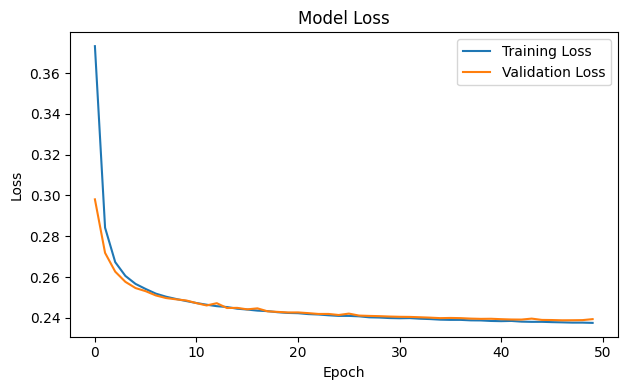

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

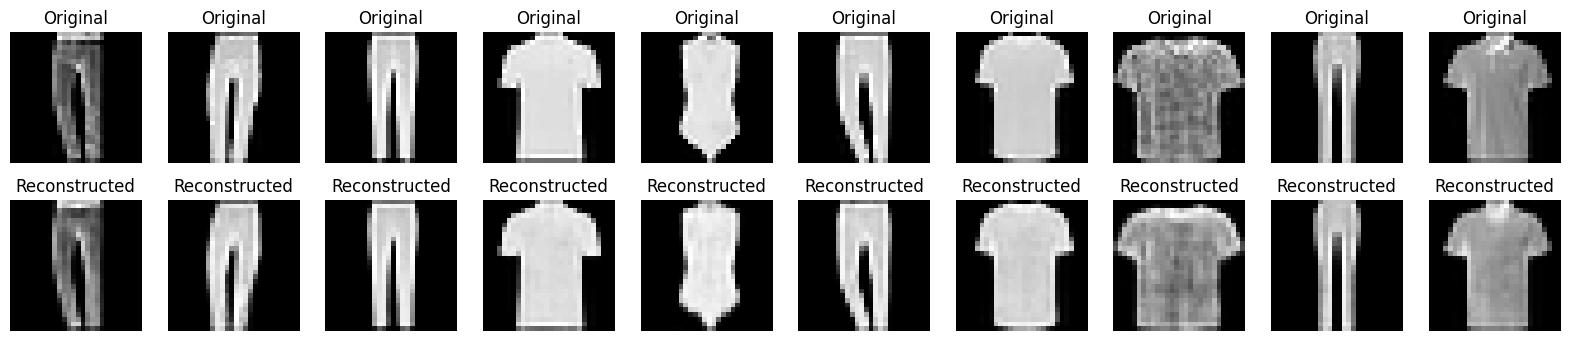

In [8]:
def visualize_reconstructions(original_images, reconstructed_images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Call the function to visualize the reconstructions
visualize_reconstructions(x_test, reconstructed_images)

# Hyperparameter Tuning

Trial 10 Complete [00h 01m 22s]
val_loss: 0.24690718948841095

Best val_loss So Far: 0.24409504234790802
Total elapsed time: 00h 08m 00s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
conv_1_units: 16
conv_2_units: 128
dense_units: 192
latent_dim: 80
Epoch 1/50
 6/44 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3920

W0000 00:00:1720384967.669727     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3294

W0000 00:00:1720384969.583704     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720384970.118373     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.3286 - val_loss: 0.2580
Epoch 2/50
 4/44 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2554

W0000 00:00:1720384970.429296     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2531 - val_loss: 0.2476
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2450 - val_loss: 0.2450
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2454 - val_loss: 0.2443
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2418 - val_loss: 0.2440
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2434 - val_loss: 0.2438
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2424 - val_loss: 0.2438
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2413 - val_loss: 0.2438
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2429 - val_loss: 0.2437
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2424 - val_loss: 0.2436
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2424 - val_loss: 0.2436
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2429 - val_loss: 0.2435
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2419 - val_

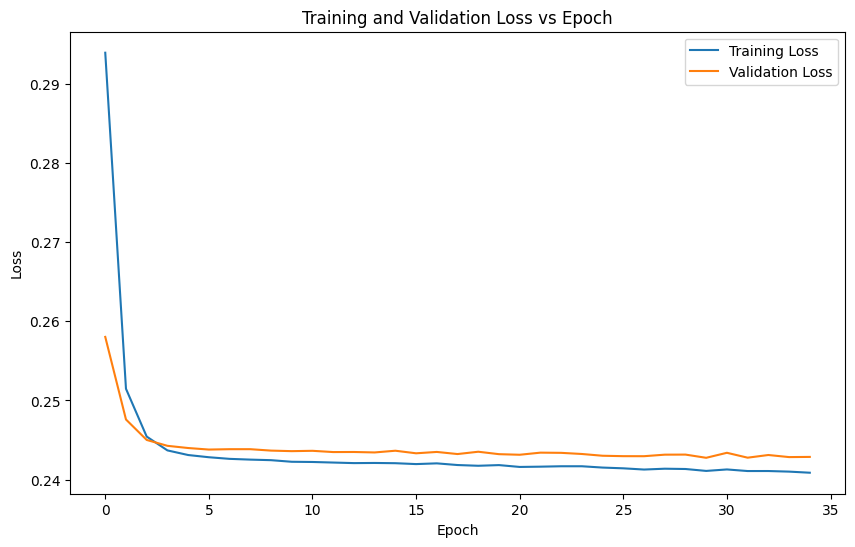

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from kerastuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# Function to build model for hyperparameter tuning
def build_model(hp):
    conv_1_units = hp.Int('conv_1_units', min_value=16, max_value=64, step=16)
    conv_2_units = hp.Int('conv_2_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    latent_dim = hp.Int('latent_dim', min_value=8, max_value=128, step=8)

    encoder = models.Sequential([
        layers.Conv2D(conv_1_units, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(conv_2_units, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(latent_dim, activation='relu', name='latent')
    ])

    # Calculate the shape after flattening
    flatten_shape = 7 * 7 * conv_2_units

    decoder = models.Sequential([
        layers.Dense(flatten_shape, activation='relu', input_shape=(latent_dim,)),
        layers.Reshape((7, 7, conv_2_units)),
        layers.Conv2DTranspose(conv_2_units, (3, 3), strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(conv_1_units, (3, 3), strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])

    autoencoder = models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                        loss='binary_crossentropy')
    return autoencoder

def calculate_ssim(original, reconstructed):
    ssim_scores = []
    for orig, recon in zip(original, reconstructed):
        ssim_scores.append(ssim(orig.squeeze(), recon.squeeze(), data_range=1.0))
    return np.mean(ssim_scores)

# Hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='autoencoder_tuning',
    project_name='fashion_mnist_autoencoder'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(x_train, x_train,
             epochs=50,
             batch_size=256,
             validation_data=(x_val, x_val),
             callbacks=[early_stopping])

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"conv_1_units: {best_hyperparameters.get('conv_1_units')}")
print(f"conv_2_units: {best_hyperparameters.get('conv_2_units')}")
print(f"dense_units: {best_hyperparameters.get('dense_units')}")
print(f"latent_dim: {best_hyperparameters.get('latent_dim')}")

# Re-train the best model to obtain the training history
history = best_model.fit(x_train, x_train,
                         epochs=50,
                         batch_size=256,
                         shuffle=True,
                         validation_data=(x_val, x_val),
                         callbacks=[early_stopping],
                         verbose=1)

# Plotting training and validation loss vs epoch
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()
plt.show()

Untuk menggunakan metode yang lebih "adil" dan realistis dalam mengoptimalkan model, saya melakukan hyperparameter tuning untuk Autoencoder menggunakan `kerastuner` dengan `RandomSearch`. Fungsi `build_model` mendefinisikan arsitektur Autoencoder dengan lapisan konvolusi dan dense yang jumlah unitnya disesuaikan secara otomatis berdasarkan hyperparameter yang diuji. Saya menggunakan `RandomSearch` untuk menemukan kombinasi terbaik dari jumlah unit di lapisan konvolusi dan dense, serta dimensi laten dan learning rate. Setelah menemukan model terbaik, saya melatihnya kembali untuk mendapatkan riwayat pelatihan (`history`). Kemudian, saya memvisualisasikan loss pelatihan dan validasi terhadap epoch menggunakan Matplotlib. Hal ini memungkinkan saya untuk mengevaluasi performa model dan memastikan bahwa model tidak overfitting atau underfitting.

32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   

W0000 00:00:1720384997.677244     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Average SSIM score on test set: 0.8731108623954766


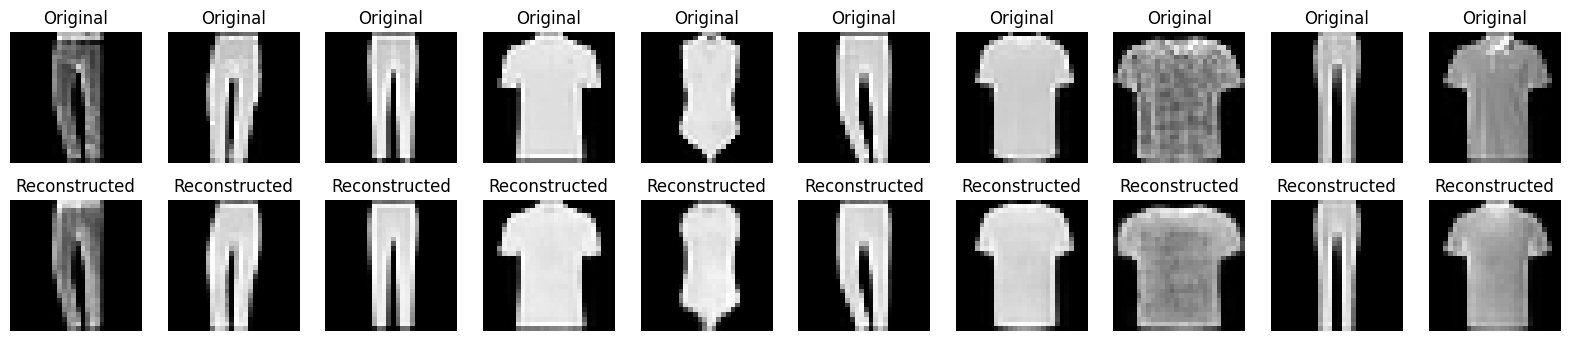

In [10]:
reconstructed_images = best_model.predict(x_test)
ssim_score = calculate_ssim(x_test, reconstructed_images)
print(f"Average SSIM score on test set: {ssim_score}")

def plot_reconstructed_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

plot_reconstructed_images(x_test, reconstructed_images)

# Kesimpulan

Berdasarkan hasil analisisnya, dapat disimpulkan bahwa manual tuning dengan menambahkan jumlah unit di lapisan encoded menjadi 512 dari 128 memberikan hasil yang lebih baik dibandingkan dengan hyperparameter tuning. Ini menunjukkan bahwa peningkatan kapasitas model dalam menangkap fitur penting dari gambar berkontribusi pada peningkatan performa model. Untuk meningkatkan hasil dari hyperparameter tuning, jumlah trial harus diperbanyak agar dapat mencoba semua kemungkinan kombinasi hyperparameter. Dengan demikian, model dapat dioptimalkan lebih baik dan hasil yang diperoleh bisa mendekati atau bahkan melampaui hasil dari manual tuning.

# D. Video

https://drive.google.com/file/d/1zSBNNMAA0HRp6NKVMvvnjm7jWOCr0JIO/view?usp=sharing